# Wind-AE

Is a `C` relaxation model with a python wrapper. **All units are cgs, unless otherwise specified.**

_**Note**: To interface directly with the `C` code, change input parameters in the `inputs/` files, then excecute from the command line with `./bin/relaxed_ae`. This can be useful for error tracing. It is reccomended to make small steps in parameter changes in the input files as relaxation methods are sensitive to having an initial guess that is close in parameter space to the goal._

The python wrapper handles post facto calculations and ramping between relaxation soltions through parameter space. It is important to note that relaxation methods are _incredibly_ sensitive to parameter choices. If you find that you are not able to reach the solution you would like to, we reccomend (a) setting a closer target in parameter space and/or (b) taking a different 'route' through parameter space (e.g., ramping a spectrum, then planet mass, instead of the other way around).

Be aware that extremely high and low gravity planets push the physial and numerical limits of this model, so caution is suggested with such solutions.  

## Table of Contents
### Loading & manipulating a planet solution
### Plotting
### Ramping to a "new planet"

In [1]:
#use Jupyter cell magic to load all of the relevant modules
%run ../wrapper/imports.py
%config InlineBackend.figure_format='retina'

Initializing the simulation class and loading a planet.
`sim.load_planet()` assumes user wants to manipulate this solution, 
so will overwrite the input files and may interrupt/corrupt any other runs being performed at the same time.

To interact with solution without overwriting input files, use `sim.load_uservars()`. This is good for printing/plotting solutions.

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
Loaded Planet:
  System parameters (cgs)               # Normalized units
    Mp:        1.330000e+30 g           #     0.70 MJ
    Rp:        1.000000e+10 cm          #     1.40 RJ
    Mstar:     1.988416e+33 g           #     1.00 Msun
    semimajor: 7.480000e+11 cm          #     0.05 au
    Ftot:      1.010286e+03 erg/cm^2/s  # 2.16e+02 FuvEarth
    Lstar:     6.807420e+33 erg/s       # 1.78e+00 Lsun


Stellar spectrum range: [1.23984255e-06 9.11648932e-06]cm
Name of spectrum: scaled-solar


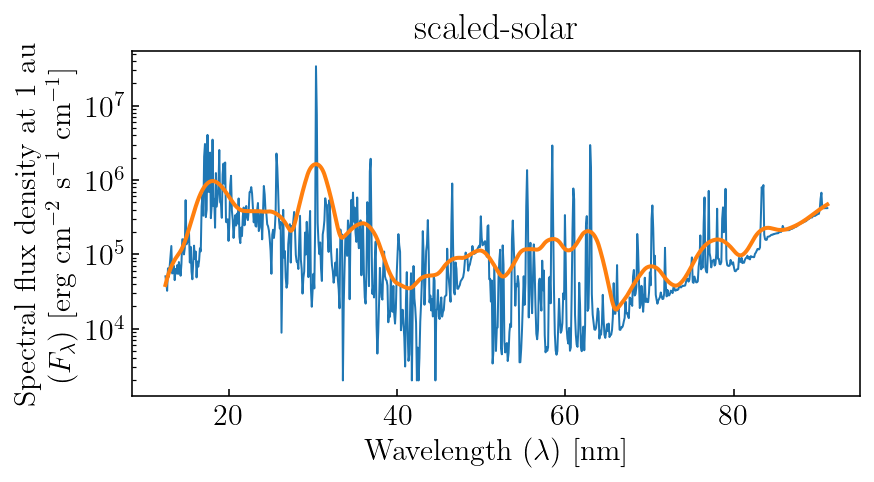

In [2]:
sim = wind_sim()

#expedite = False means load all post facto calculations
sim.load_planet('saves/HD209458b/HD209_13.6-100eV_H-He.csv',
               expedite=False,
               print_atmo_composition=True) 

#print planet parameters
sim.system.print_system(norm='Jupiter')

#print spectrum parameters
print(f"\nStellar spectrum range: {sim.windsoln.spec_window}cm")
print(f"Name of spectrum: {sim.windsoln.spectrum_tuple[3]}")
#Wind-AE used the smoothed spectrum in orange
sim.spectrum.plot()
plt.show()

#### Running a solution
`sim.run_wind()` will run the relaxation code with the initial guess as was loaded in the `sim.load_planet()` and will attempt to ramp from that guess to the solution parameters that are specified in the `input files`. It will return 0 if successful, 1 if unsuccesful.

The solution for HD209458b with H/He with mass fractions of 0.8/0.2 and the EUV stellar spectrum range (13.6-100eV) is now loaded.

#### To ramp to the full XUV range (13.6-2000eV)

In [3]:
#Fnorm is the flux in ergs/s/cm2 AT THE PLANET w/in the spec range
#listed in 'norm_spec_range'
sim.ramp_spectrum(Fnorm=450,norm_spec_range=[13.6,40],
                 goal_spec_range=[13.6,2000],units='eV')

Goal: [ 0.61992127 91.16489319] nm
Ramped spectrum wavelength range, now normalizing spectrum. 
Ramping Ftot from 1.010e+03 to 1.096e+03.                                                                   
  Final:  Ftot:1.095713e+03, delta:0.0224                                                                      


0

#### Save solution

In [4]:
sim.save_planet('saves/HD209458b/HD209_13.6-2000eV_H-He.csv',
                overwrite=True)

Saving saves/HD209458b/HD209_13.6-2000eV_H-He.csv


#### Performing post-facto calculations
The relaxation solution returns:
- Density
- Temperature
- Velocity
- Neutral fraction (=1-Ionization fraction) _per species_
- Column density (proxy for $\tau$) _per species_

The python wrapper then computes a large number of post-facto variables which can be loaded with `sim.load_uservars('path/to/solution')` or added to an already loaded windsoln with `sim.windsoln.add_user_vars()`. To interface with these variables, use the `sim.windsoln` object.

_Note: If you recieve a `KeyError` or an error about `sim.windsoln.r_cori` this indicates that the post-facto calcs have not been loaded, so try running `sim.load_uservars()`. This will load the variables from the latest simulation in the `sim` class - in this case, the full XUV HD209 solution we just generated._

In [5]:
#access the post-facto solutions
sim.windsoln.soln['T']
sim.windsoln.soln_norm['v'] 
# sim.windsoln.soln['v'] is sim.windsoln.scales_dict['v']*sim.windsoln.soln_norm['v']
sim.windsoln.add_user_vars() #see Note
sim.windsoln.soln['mu']

0       3.848590e-24
1       3.848505e-24
2       3.848416e-24
3       3.848324e-24
4       3.848227e-24
            ...     
1496    1.050918e-24
1497    1.050910e-24
1498    1.050903e-24
1499    1.050896e-24
1500    1.050888e-24
Name: mu, Length: 1501, dtype: float64

### Plotting
Several useful plotting functions are included in `Wind-AE`.

`energy_plot()` plots the heating and net cooling as a function of radius in units of Rp.

`six_panel_plot()` plots density, temperature, velocity, number density (per species), ionization fraction (per species), and column density (per species) as a function of radius in units of Rp.

`quick_plot()` just does density, temp, velocity, and ionization fraction.

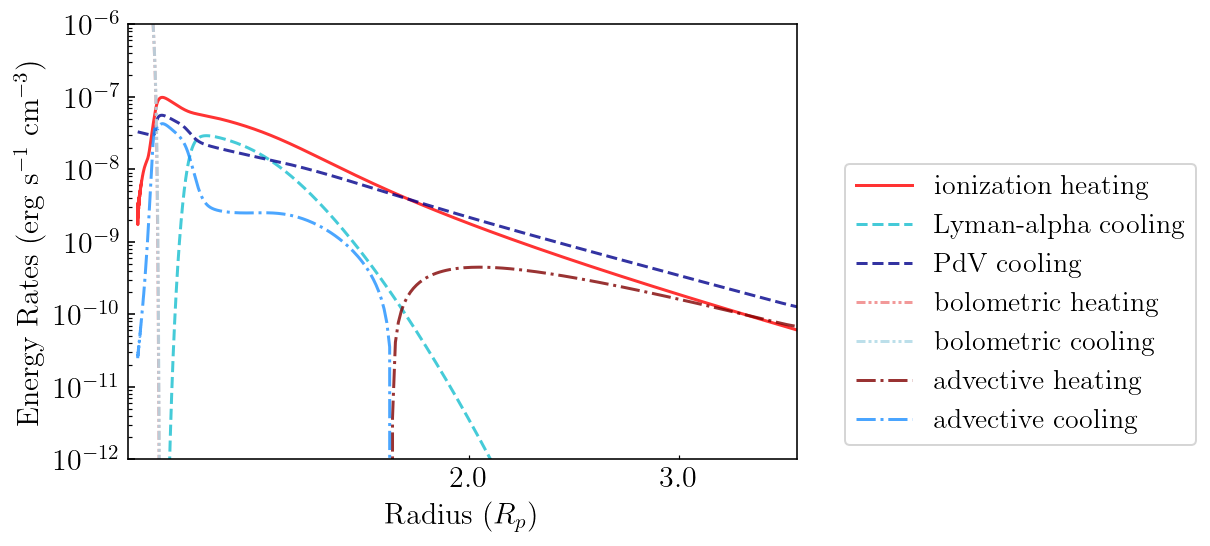

In [6]:
energy_plot(sim.windsoln)

## Ramping to "new planet"

New planets can be created by suppling a planetary mass ($M_\mathrm{p}$), planetary radius ($R_\mathrm{p}$), stellar mass ($M_\star$), semimajor-axis ($a$), stellar *bolometric* luminosity ($L_\star$) and the total integrated ionizing flux ($F_\mathrm{tot}$) to the `system` object.

In [7]:
#initializing system object
HD189733b = system(1.162*const.Mjupiter, 1.138*const.Rjupiter,
                   0.846*const.Msun, 0.031*const.au, 
                   2000,0.328*const.Lsun,
                   name='HD 189733 b') #Rstar = 0.8*Rsun

HD189733b.print_system(norm='Jupiter')

HD 189733 b:
  System parameters (cgs)               # Normalized units
    Mp:        2.206084e+30 g           #     1.16 MJ
    Rp:        8.135790e+09 cm          #     1.14 RJ
    Mstar:     1.682200e+33 g           #     0.85 Msun
    semimajor: 4.637600e+11 cm          #     0.03 au
    Ftot:      2.000000e+03 erg/cm^2/s  # 4.29e+02 FuvEarth
    Lstar:     1.255584e+33 erg/s       # 3.28e-01 Lsun



It is possible to ramp all parameters to the desired solution using

`sim.ramp_to()`

or individual parameters using the following functions:

 - `sim.ramp_var()` - $F_{tot}$
 - `sim.ramp_star()` - $M_\star$,$a$, $L_\star$
 - `sim.ramp_grav()` - $M_p$, $R_p$

In [9]:
#load the planet we would like to ramp from as a guess
sim.load_planet('saves/HD209458b/HD209_13.6-2000eV_H-He.csv')

sim.ramp_to(system=HD189733b)

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
Ramping Ftot from 1.096e+03 to 2.000e+03.                                                     
  Trying: Ftot:1.162332e+03, delta:0.04                                                                      

KeyboardInterrupt: 

#### Polishing Boundary Conditions
`sim.polish_bcs()` contains:
1. `sim.ramp_base_bcs()` ramps lower BCs - note that the default pressure of the lower boundary is 1 $\mu$bar, but it can be set lower in the atmosphere by setting `user_override_press=True` and `base_press=` in microbars. Ramping this can be expensive and it is difficult for the relaxation code to reach the physical lower boundary conditions computed by the balance of bolometric heating and cooling below the wind (values that can be printed using `sim.base_bcs(user_override_press=,base_press=)`). Subsequent runs of this solution will maintain that user-defined lower boundary condition.

2. `sim.run_isotherm()` checks that the transition from molecular below the wind to atomic in the wind is at the appropriate radius in the solution. Running `sim.erf_velocity()` will print the computed drop-off rate and drop-off location of the complimentary error function that governs this transition.

3. `sim.converge_Ncol_sp()` converges column density at sonic point to self consistent value. May temporarily stop integrating outwards beyond the sonic point.

4. `sim.converge_Rmax()` sets the maximum radius of the solution at the coriolis radius. Will not run if `sim.polish_bcs(converge_Rmax=False)`

We can then plot a comparison of the solutions

***** HD 209548b: Mdot = 1.96e+10 g/s *****
***** HD 189733b: Mdot = 2.02e+10 g/s *****


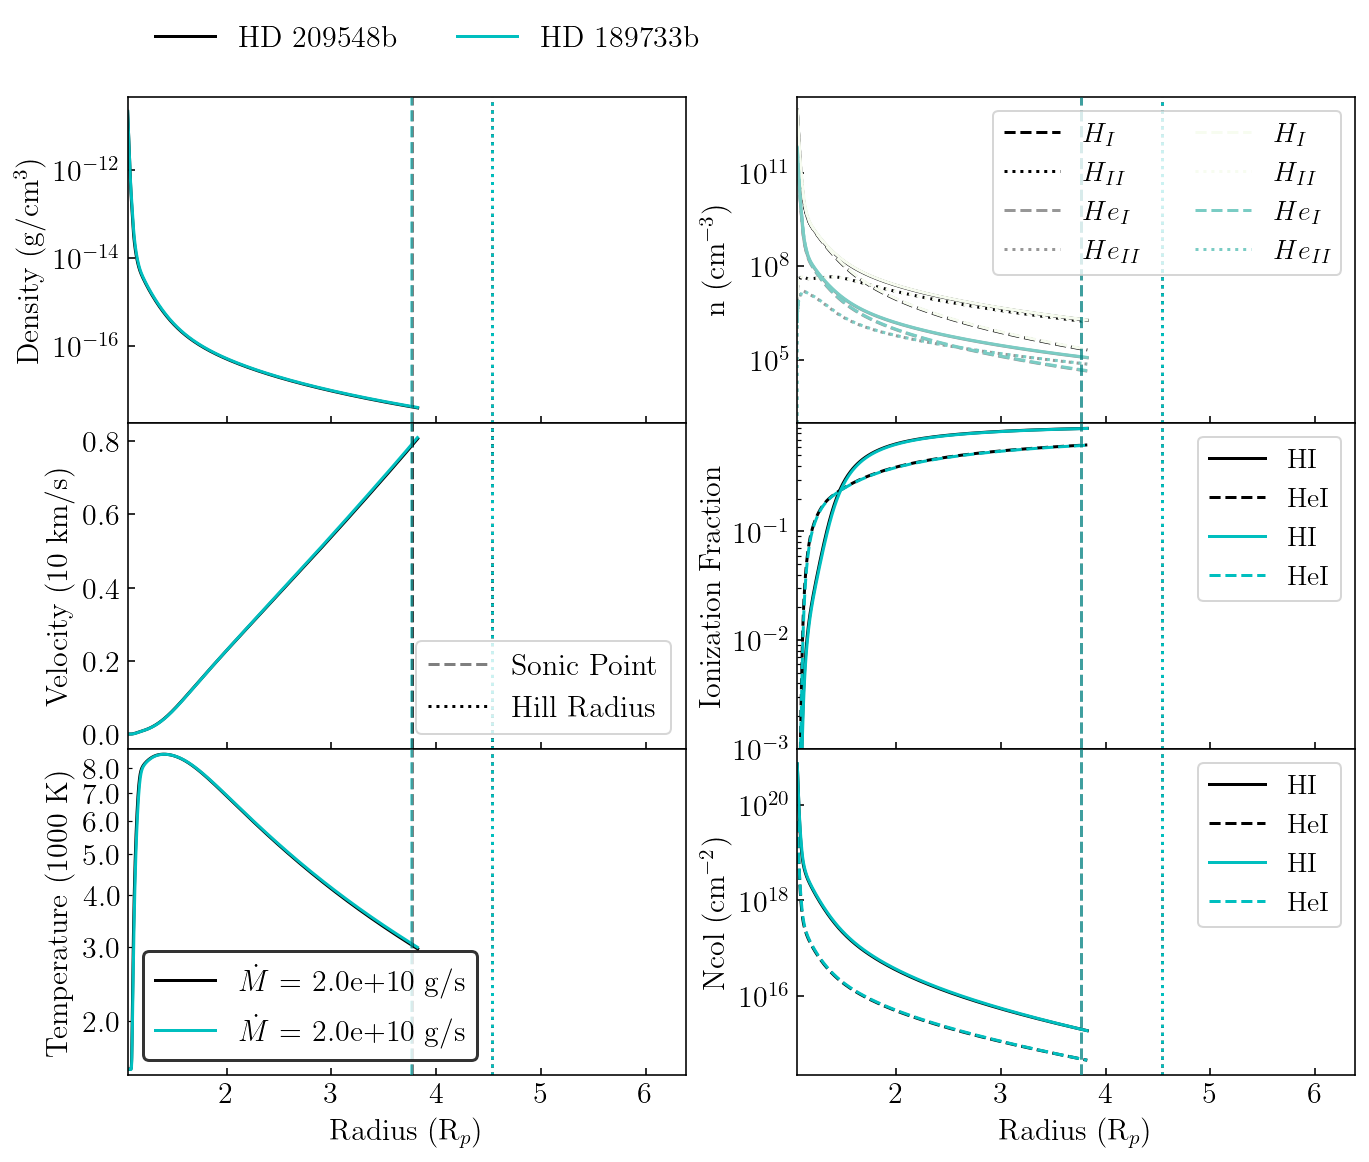

In [19]:
#Load the solution another sim.windsoln object to compare
sim_209 = wind_sim()
sim_209.load_uservars('saves/HD209458b/HD209_13.6-2000eV_H-He.csv') 
#computing user vars for an already loaded windsoln object 
sim.windsoln.add_user_vars() #HD189733b solution

#To plot comparisons
ax = six_panel_plot(sim_209.windsoln,
                    line_label='HD 209548b',line_color='k')
six_panel_plot(sim.windsoln,first_plotted=False,ax=ax,
               line_label='HD 189733b',line_color='c')

#### Directly changing inputs (rather than ramping)
Whether `Wind-AE` has used the Numerical Recipes Bulirsch-Stoer ODE integrator to integrate beyond the sonic point depends on the flag

`integrate_out=True`

**  **Outward integration is not necessary to compute $\dot{M}$.** **

To directly manipulte the flags or any of the input conditions, one can edit the values in the `inputs/` files or interface with them through the python wrapper using the `sim.inputs` object

e.g., `sim.inputs.write_flags(1,1,1,1,integrate_out=True)`

```
print('Current flags are', sim.windsoln.flags_tuple)
sim.inputs.write_flags(1,1,1,1,integrate_out=True)
sim.run_wind() #then run relaxation code with new inputs
```

### Ramping to custom user stellar spectrum
`sim.format_user_spectrum()` - Takes flux in at 1 au as a function of wavelength, wavlength, a new spectrum savefile name.

`sim.ramp_to_user_spectrum()` - Ramps to a desired user-defined spectrum.

In [ ]:
# sim.format_user_spectrum()
sim.ramp_to_user_spectrum('your spectrum here',
                         species_list=['HI','HeI'],
                         Fnorm=400, norm_spec_range=[13.6,100],
                         goal_spec_range=[13.6,2000], units='eV')

### Adding Metals
Adding metals to the solution increases the expense of the relaxation code as $n_{metals}$, so it is reccomended to add metals as a last step.

Metals are ramped in with solar metallicity. After they have been ramped in, one can change the metallicity in factors of solar metallicity or ramp to a custom set of *mass* fractions. 

In [ ]:
sim.add_metals(['CI','NI','OI'])

In [ ]:
sim.ramp_metallicity(custom_mfs=[])

In [ ]:
sim.save_planet('saves/HD187933b/HD187933b_13.6-2000eV_H-He-C-N-O.csv')

### Easy export
The Wind-AE wrapper is equipped to read the solution files generated by the `C` code, but it is often easier to have a simple save file to share with collaborators.